In [1]:
import torch
import torch.nn as nn


def cal_anisotropy(model_emb):
    model_emb = model_emb / torch.norm(model_emb, dim=-1, keepdim=True)
    cos_similarity = torch.mm(model_emb, model_emb.T).sum() - model_emb.size(0)
    anisotropy = cos_similarity / model_emb.size(0) / (model_emb.size(0) - 1)
    return anisotropy


# Parameters
vocab_size = 30522
embedding_dim = 128
embedding_std = 0.1
noise_mean = 0.08

# Create Embedding layer
embedding = nn.Embedding(vocab_size, embedding_dim)
nn.init.normal_(embedding.weight, mean=0.0, std=embedding_std)

# Create Linear layer sharing weights with Embedding
linear = nn.Linear(embedding_dim, vocab_size, bias=False)
linear.weight = embedding.weight

# Generate random token IDs
token_ids = torch.randint(0, vocab_size, (1, 10))  # Example batch of 10 tokens

# Get embeddings
embeddings = embedding(token_ids)

# Get linear layer outputs (logits) without noise
logits_original = linear(embeddings)
predicted_token_ids_original = torch.argmax(logits_original, dim=-1)

# Add noise to embeddings
noise = torch.normal(
    mean=noise_mean, std=0.3, size=embeddings.size()
)  # standard deviation of 1 is chosen to make the noise effect noticeable.
noisy_embeddings = embeddings + noise

# Get linear layer outputs (logits) with noise
logits_noisy = linear(noisy_embeddings)
predicted_token_ids_noisy = torch.argmax(logits_noisy, dim=-1)

# Compare predicted token IDs
print("Original Predicted Token IDs:", predicted_token_ids_original)
print("Noisy Predicted Token IDs:", predicted_token_ids_noisy)

# Calculate the number of changed tokens
changed_tokens = torch.sum(predicted_token_ids_original != predicted_token_ids_noisy).item()
print(f"Number of changed tokens: {changed_tokens}")

# Calculate the percentage of changed tokens
percentage_changed = (changed_tokens / token_ids.numel()) * 100
print(f"Percentage of changed tokens: {percentage_changed:.2f}%")

mse_loss = torch.nn.functional.mse_loss(noisy_embeddings, embeddings)
print("MSE Loss:", mse_loss)

# Optionally, you can analyze the differences in logits:
# print("Original Logits:", logits_original)
# print("Noisy Logits:", logits_noisy)
# print("Difference in Logits:", logits_noisy - logits_original)

Original Predicted Token IDs: tensor([[14694, 13293, 14285, 13111, 29432,  7418, 14067, 18197,  3875, 21200]])
Noisy Predicted Token IDs: tensor([[ 4130,   892, 28226, 21131, 18887, 14092, 14067,  7717,  3432, 21200]])
Number of changed tokens: 8
Percentage of changed tokens: 80.00%
MSE Loss: tensor(0.0882, grad_fn=<MseLossBackward0>)


## Anisotropy Calculation

In [2]:
print("Anisotropy of Original Embeddings:", cal_anisotropy(embedding.weight))

Anisotropy of Original Embeddings: tensor(-1.3611e-06, grad_fn=<DivBackward0>)


In [3]:
def generate_embeddings_with_anisotropy(n_samples, embedding_dim, target_anisotropy, max_iterations=10):
    """Generate embeddings with a specified anisotropy level.

    Args:
        n_samples (int): Number of embedding vectors
        embedding_dim (int): Dimension of each embedding vector
        target_anisotropy (float): Desired anisotropy level (between 0 and 1)
        max_iterations (int): Maximum iterations for optimization

    Returns:
        torch.Tensor: Embeddings with shape (n_samples, embedding_dim)

    """
    # Validate input
    if not 0 <= target_anisotropy <= 1:
        raise ValueError("Target anisotropy must be between 0 and 1")

    # Initialize random embeddings
    embeddings = torch.randn(n_samples, embedding_dim)
    embeddings = embeddings / torch.norm(embeddings, dim=-1, keepdim=True)

    # Optimization parameters
    learning_rate = 0.1
    tolerance = 1e-3

    for iteration in range(max_iterations):
        # Calculate current anisotropy
        cos_sim = torch.mm(embeddings, embeddings.T)
        current_anisotropy = (cos_sim.sum() - n_samples) / (n_samples * (n_samples - 1))

        # Check if we're close enough to target
        if abs(current_anisotropy - target_anisotropy) < tolerance:
            break

        # Calculate gradient
        grad = torch.mm(embeddings.T, cos_sim) - embeddings * torch.diagonal(cos_sim).unsqueeze(1)
        grad = grad / torch.norm(grad)

        # Update embeddings
        adjustment = learning_rate * grad.T
        embeddings = embeddings - adjustment

        # Re-normalize
        embeddings = embeddings / torch.norm(embeddings, dim=-1, keepdim=True)

        # Reduce learning rate over time
        learning_rate *= 0.99

    # Final normalization
    embeddings = embeddings / torch.norm(embeddings, dim=-1, keepdim=True)

    # Verify final anisotropy
    final_anisotropy = cal_anisotropy(embeddings)
    print(f"Final anisotropy: {final_anisotropy.item():.4f} (Target: {target_anisotropy})")

    return embeddings

In [4]:
import torch
import torch.nn as nn


def generate_embeddings_with_anisotropy(n_samples, embedding_dim, target_anisotropy):
    """Generate embeddings with specified anisotropy using a faster method."""
    if not 0 <= target_anisotropy <= 1:
        raise ValueError("Target anisotropy must be between 0 and 1")

    # Start with random embeddings
    embeddings = torch.randn(n_samples, embedding_dim)
    embeddings = embeddings / torch.norm(embeddings, dim=-1, keepdim=True)

    # Calculate desired average cosine similarity
    # For anisotropy = sum(cos_sim - n)/(n*(n-1)), we want cos_sim to achieve this
    desired_avg_cos = target_anisotropy * (n_samples - 1) / n_samples

    # Use a mixture of orthogonal and correlated components
    # Orthogonal base
    ortho_dim = min(n_samples, embedding_dim)
    ortho_embeddings = torch.randn(n_samples, ortho_dim)
    ortho_embeddings = torch.nn.functional.normalize(ortho_embeddings, dim=-1)

    # Add correlated component to achieve desired anisotropy
    correlation_factor = torch.sqrt(torch.tensor(desired_avg_cos / (1 - desired_avg_cos) + 1e-6))
    common_vector = torch.randn(1, embedding_dim)
    common_vector = common_vector / torch.norm(common_vector)

    # Combine orthogonal and correlated parts
    if embedding_dim > ortho_dim:
        extra_dims = torch.randn(n_samples, embedding_dim - ortho_dim)
        extra_dims = torch.nn.functional.normalize(extra_dims, dim=-1)
        ortho_embeddings = torch.cat([ortho_embeddings, extra_dims], dim=-1)

    embeddings = (ortho_embeddings + correlation_factor * common_vector) / (1 + correlation_factor)
    embeddings = embeddings / torch.norm(embeddings, dim=-1, keepdim=True)

    final_anisotropy = cal_anisotropy(embeddings)
    print(f"Final anisotropy: {final_anisotropy.item():.4f} (Target: {target_anisotropy})")
    return embeddings


def cal_anisotropy(model_emb):
    model_emb = model_emb / torch.norm(model_emb, dim=-1, keepdim=True)
    cos_similarity = torch.mm(model_emb, model_emb.T).sum() - model_emb.size(0)
    anisotropy = cos_similarity / model_emb.size(0) / (model_emb.size(0) - 1)
    return anisotropy


def create_anisotropic_embedding_layer(vocab_size, embedding_dim, target_anisotropy):
    embeddings = generate_embeddings_with_anisotropy(
        n_samples=vocab_size,
        embedding_dim=embedding_dim,
        target_anisotropy=target_anisotropy,
    )
    return nn.Embedding.from_pretrained(embeddings, freeze=False)

In [5]:
# Your exact parameters
vocab_size = 30522
embedding_dim = 128
embedding_std = 0.2
noise_mean = 0.08

# Create the anisotropic embedding layer
anisotropic_embedding = create_anisotropic_embedding_layer(vocab_size, embedding_dim, 0.5)

# Create a linear layer with correct dimensions
linear = nn.Linear(embedding_dim, vocab_size, bias=False)
linear.weight.data = anisotropic_embedding.weight.data.clone()

# Calculate anisotropy
anisotropy = cal_anisotropy(anisotropic_embedding.weight)
print(f"Anisotropy: {anisotropy:.4f}")

# Example usage with noise
token_ids = torch.randint(0, vocab_size, (1, 10))
embeddings = anisotropic_embedding(token_ids)

noise = torch.normal(mean=noise_mean, std=embedding_std, size=embeddings.size())
noisy_embeddings = embeddings + noise

logits_original = linear(embeddings)
logits_noisy = linear(noisy_embeddings)

predicted_token_ids_original = torch.argmax(logits_original, dim=-1)
predicted_token_ids_noisy = torch.argmax(logits_noisy, dim=-1)

print(f"Input token ids:      {token_ids}")
print(f"Original token ids:   {predicted_token_ids_original}")
print(f"Noisy token ids:      {predicted_token_ids_noisy}")

changed_tokens = torch.sum(predicted_token_ids_original != predicted_token_ids_noisy).item()
print(f"Number of changed tokens: {changed_tokens}")

percentage_changed = (changed_tokens / token_ids.numel()) * 100
print(f"Percentage of changed tokens: {percentage_changed:.2f}%")

mse_loss = torch.nn.functional.mse_loss(noisy_embeddings, embeddings)
print(f"MSE Loss: {mse_loss:.4f}")

Final anisotropy: 0.4990 (Target: 0.5)
Anisotropy: 0.4990
Input token ids:      tensor([[27771, 25099, 14131,  4840,  1692, 21310, 10351, 30385,  7789, 23414]])
Original token ids:   tensor([[27771, 25099, 14131,  4840,  1692, 21310, 10351, 30385,  7789, 23414]])
Noisy token ids:      tensor([[25937, 25099, 16772,  8878, 29768, 17436,  7202,  1406,  8876, 22901]])
Number of changed tokens: 9
Percentage of changed tokens: 90.00%
MSE Loss: 0.0475


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch


def analyze_l2_distances(anisotropic_emb, regular_emb, sample_size=1000):
    """Compute and visualize L2 distance statistics between embeddings.

    Args:
        anisotropic_emb (torch.Tensor): Anisotropic embedding weights (vocab_size, embedding_dim)
        regular_emb (torch.Tensor): Regular embedding weights (vocab_size, embedding_dim)
        sample_size (int): Number of embeddings to sample for distance computation

    """
    # Convert to numpy and sample
    aniso_np = anisotropic_emb.detach().cpu().numpy()
    reg_np = regular_emb.detach().cpu().numpy()
    indices = np.random.choice(aniso_np.shape[0], min(sample_size, aniso_np.shape[0]), replace=False)
    aniso_sample = aniso_np[indices]
    reg_sample = reg_np[indices]

    # Compute pairwise L2 distances
    def compute_pairwise_l2(embeddings):
        # Convert to torch for efficient computation
        emb = torch.from_numpy(embeddings)
        # Compute squared differences
        diff = emb.unsqueeze(0) - emb.unsqueeze(1)  # [sample_size, sample_size, embedding_dim]
        distances = torch.norm(diff, p=2, dim=2)  # [sample_size, sample_size]
        # Get upper triangle excluding diagonal
        triu_indices = torch.triu_indices(sample_size, sample_size, offset=1)
        return distances[triu_indices[0], triu_indices[1]].numpy()

    aniso_distances = compute_pairwise_l2(aniso_sample)
    reg_distances = compute_pairwise_l2(reg_sample)

    # Compute statistics
    aniso_stats = {
        "mean": np.mean(aniso_distances),
        "std": np.std(aniso_distances),
        "min": np.min(aniso_distances),
        "max": np.max(aniso_distances),
    }
    reg_stats = {
        "mean": np.mean(reg_distances),
        "std": np.std(reg_distances),
        "min": np.min(reg_distances),
        "max": np.max(reg_distances),
    }

    # Print statistics
    print("Anisotropic Embeddings L2 Distance Statistics:")
    for key, value in aniso_stats.items():
        print(f"{key}: {value:.4f}")
    print("\nRegular Embeddings L2 Distance Statistics:")
    for key, value in reg_stats.items():
        print(f"{key}: {value:.4f}")

    # Visualize histograms
    plt.figure(figsize=(12, 6))
    plt.hist(
        aniso_distances,
        bins=50,
        alpha=0.7,
        color="blue",
        label="Anisotropic",
        density=True,
    )
    plt.hist(reg_distances, bins=50, alpha=0.7, color="red", label="Regular", density=True)
    plt.title(f"L2 Distance Distribution (Sampled {sample_size} embeddings)")
    plt.xlabel("L2 Distance")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [6]:
import torch
from sklearn.manifold import TSNE


def visualize_embeddings_shared_space(anisotropic_emb, regular_emb, sample_size=500, perplexity=30, n_iter=1000):
    """Visualize anisotropic and regular embeddings in a shared t-SNE space.

    Args:
        anisotropic_emb (torch.Tensor): Anisotropic embedding weights (vocab_size, embedding_dim)
        regular_emb (torch.Tensor): Regular embedding weights (vocab_size, embedding_dim)
        sample_size (int): Number of embeddings to sample for visualization
        perplexity (int): t-SNE perplexity parameter
        n_iter (int): Number of iterations for t-SNE optimization

    """
    # Convert to numpy
    aniso_np = anisotropic_emb.detach().cpu().numpy()
    reg_np = regular_emb.detach().cpu().numpy()

    # Sample same indices for both to maintain correspondence
    indices = np.random.choice(aniso_np.shape[0], min(sample_size, aniso_np.shape[0]), replace=False)
    aniso_sample = aniso_np[indices]
    reg_sample = reg_np[indices]

    # Combine into one dataset for shared t-SNE projection
    combined = np.vstack([aniso_sample, reg_sample])
    tsne = TSNE(
        n_components=2,
        perplexity=min(perplexity, sample_size - 1),
        n_iter=n_iter,
        random_state=42,
    )
    combined_2d = tsne.fit_transform(combined)

    # Split back into separate sets
    aniso_2d = combined_2d[:sample_size]
    reg_2d = combined_2d[sample_size:]

    # Plot both on same axes
    plt.figure(figsize=(12, 10))
    plt.scatter(
        aniso_2d[:, 0],
        aniso_2d[:, 1],
        s=30,
        c="blue",
        alpha=0.7,
        label=f"Anisotropic (anisotropy: {cal_anisotropy(anisotropic_emb):.4f})",
    )
    plt.scatter(
        reg_2d[:, 0],
        reg_2d[:, 1],
        s=30,
        c="red",
        alpha=0.7,
        label=f"Regular (anisotropy: {cal_anisotropy(regular_emb):.4f})",
    )
    plt.title(f"Embedding Comparison in Shared t-SNE Space (Sampled {sample_size} points)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Your cal_anisotropy function (needed for labels)
def cal_anisotropy(model_emb):
    model_emb = model_emb / torch.norm(model_emb, dim=-1, keepdim=True)
    cos_similarity = torch.mm(model_emb, model_emb.T).sum() - model_emb.size(0)
    anisotropy = cos_similarity / model_emb.size(0) / (model_emb.size(0) - 1)
    return anisotropy

ModuleNotFoundError: No module named 'sklearn'

In [7]:
vocab_size = 30522
embedding_dim = 128

Final anisotropy: 0.4987 (Target: 0.5)
Anisotropic Embeddings L2 Distance Statistics:
mean: 1.0005
std: 0.0536
min: 0.7746
max: 1.2297

Regular Embeddings L2 Distance Statistics:
mean: 15.9991
std: 1.0065
min: 11.3518
max: 20.7913


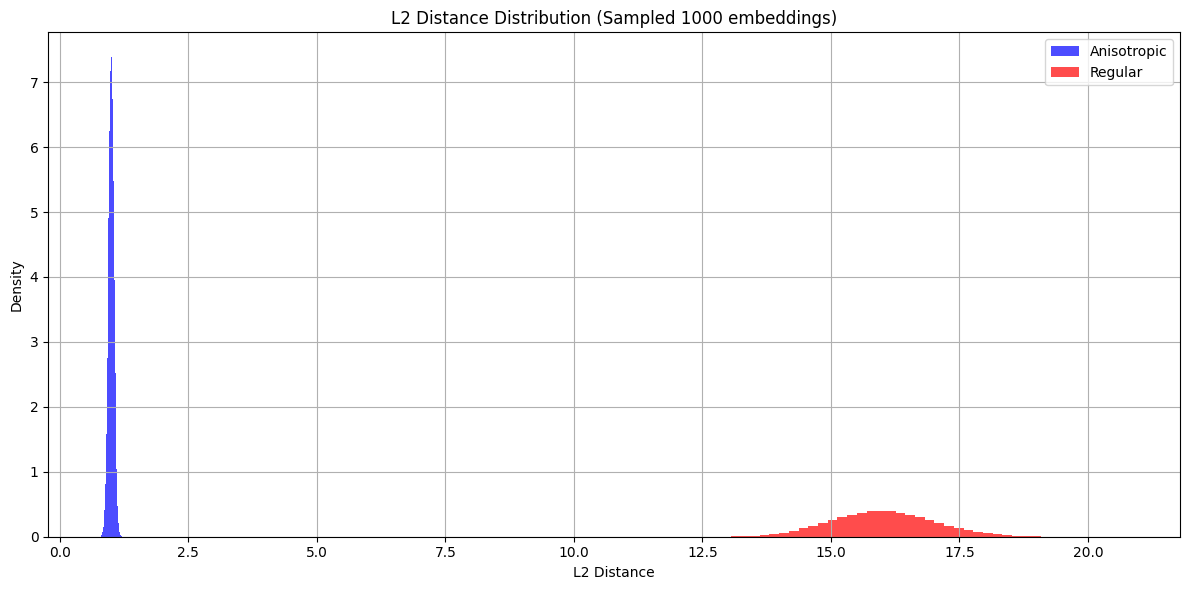

In [8]:
regular_embedding = nn.Embedding(vocab_size, embedding_dim)
torch.nn.init.normal_(regular_embedding.weight, mean=0, std=1.0)


anisotropic_embedding = create_anisotropic_embedding_layer(vocab_size, embedding_dim, 0.5)

# Visualize in shared space
# visualize_embeddings_shared_space(anisotropic_embedding.weight, regular_embedding.weight)
analyze_l2_distances(anisotropic_embedding.weight, regular_embedding.weight)

In [9]:
def isotropy_loss(embeddings):
    norm_emb = embeddings / torch.norm(embeddings, dim=-1, keepdim=True)
    cos_sim = torch.mm(norm_emb, norm_emb.T)
    off_diag = cos_sim - torch.eye(cos_sim.size(0), device=cos_sim.device)
    return torch.mean(off_diag**2)

In [10]:
isotropy_loss(anisotropic_embedding.weight)

tensor(0.2517, grad_fn=<MeanBackward0>)

In [11]:
isotropy_loss(regular_embedding.weight)

tensor(0.0078, grad_fn=<MeanBackward0>)

In [14]:
import torch


def visualize_closest_embedding_distances(
    embeddings,
    sample_size=1000,
    title="Distribution of Closest Embedding Distances",
    bins=50,
):
    """Compute and visualize the distribution of L2 distances to the closest embedding, with sampling.

    Args:
        embeddings (torch.Tensor): Embedding weights of shape (n_samples, embedding_dim)
        sample_size (int): Number of embeddings to sample for computation
        title (str): Title for the plot
        bins (int): Number of bins for the histogram

    """
    # Sample a subset to avoid memory issues
    n_samples = embeddings.size(0)
    sample_size = min(sample_size, n_samples)  # Ensure we don’t exceed available embeddings
    indices = torch.randperm(n_samples)[:sample_size]
    sampled_emb = embeddings[indices]

    # Normalize embeddings (optional; remove if raw distances are preferred)
    norm_emb = sampled_emb / torch.norm(sampled_emb, dim=-1, keepdim=True)

    # Compute pairwise L2 distances
    diff = norm_emb.unsqueeze(0) - norm_emb.unsqueeze(1)  # Shape: (sample_size, sample_size, embedding_dim)
    distances = torch.norm(diff, p=2, dim=2)  # Shape: (sample_size, sample_size)

    # Mask self-distances with a large value
    distances = distances + torch.eye(sample_size, device=embeddings.device) * 1e10

    # Get distance to closest neighbor for each embedding
    min_distances = torch.min(distances, dim=1)[0]  # Shape: (sample_size,)

    # Convert to numpy for plotting
    min_distances_np = min_distances.detach().cpu().numpy()

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(min_distances_np, bins=bins, alpha=0.7, color="blue", density=True)
    plt.title(f"{title} (Sampled {sample_size} embeddings)")
    plt.xlabel("L2 Distance to Closest Embedding")
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print basic statistics
    avg_dist = min_distances.mean().item()
    std_dist = min_distances.std().item()
    print(f"Average distance: {avg_dist:.4f}")
    print(f"Standard deviation: {std_dist:.4f}")
    print(f"Min distance: {min_distances.min().item():.4f}")
    print(f"Max distance: {min_distances.max().item():.4f}")

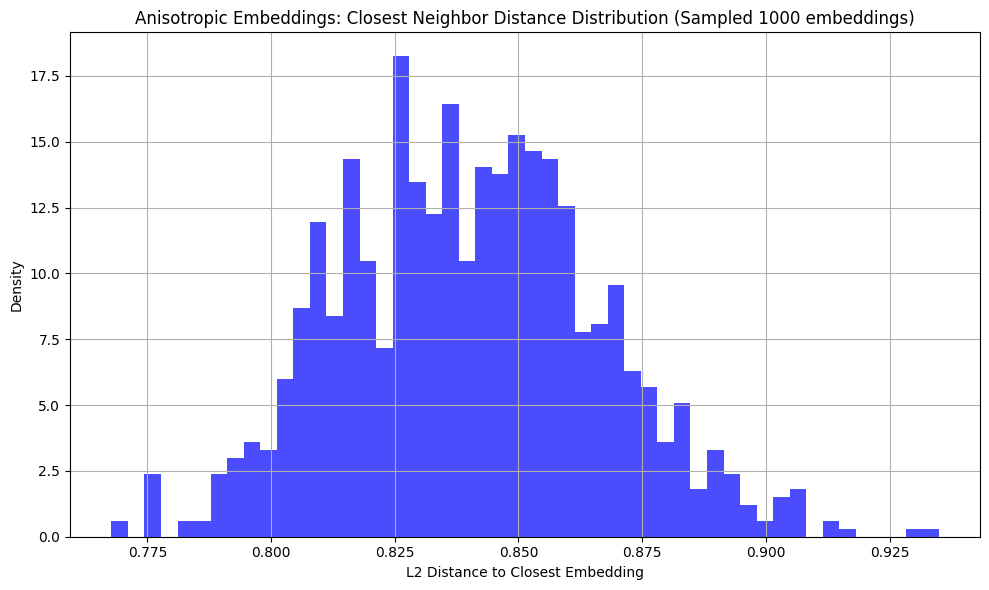

Average distance: 0.8403
Standard deviation: 0.0263
Min distance: 0.7677
Max distance: 0.9349


In [15]:
visualize_closest_embedding_distances(
    anisotropic_embedding.weight,
    title="Anisotropic Embeddings: Closest Neighbor Distance Distribution",
)

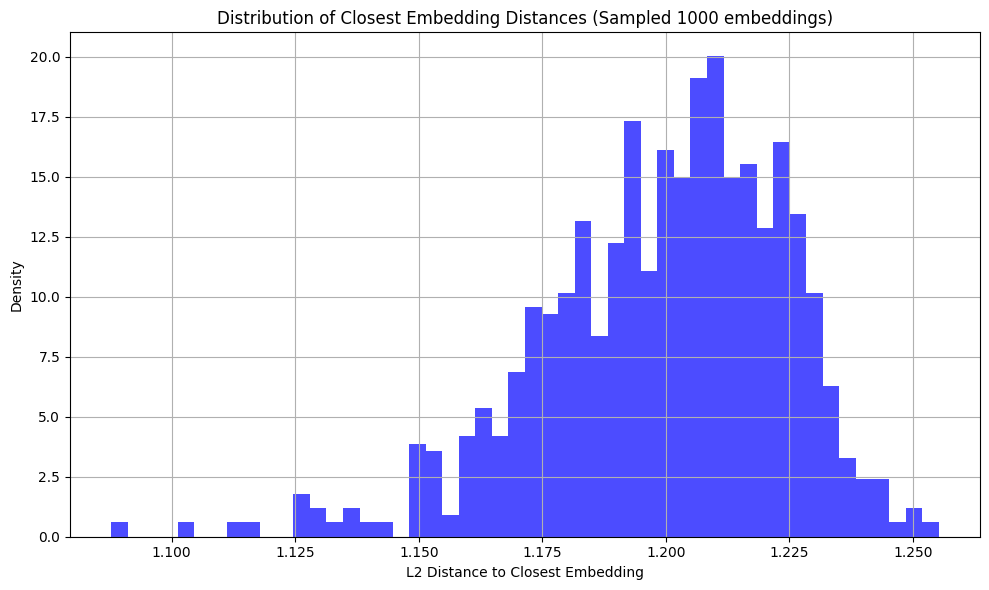

Average distance: 1.1992
Standard deviation: 0.0249
Min distance: 1.0878
Max distance: 1.2552


In [16]:
visualize_closest_embedding_distances(regular_embedding.weight)